In [41]:
import pandas as pd
import numpy as np

## Limpieza de datos
Para esta fase se tomó el dataset y se eliminaron las coloumnas inncesarias, ademas se dividen campos como fechas y se cambia su tipo para tener homogeneidad en el dataset, y por último se borran las datos atípicos en la fecha de recepción real. Este proceso se hizo más directo debido a la experiencia previa con los trabajos anteriores en los que se manipulaba el dataset de manera similar.

In [42]:
data = pd.read_excel("Copia de Compras.xls")
data.drop(["Cod_Motivo_Compra"], axis = "columns", inplace = True)
data.dropna(how = "all", inplace = True)

newData = data["Id_Proveedor_Sucursal"].str.split("|", n = 1, expand = True)
data.insert(2, column = "id_Proveedor", value = newData[0])
data.insert(3, column = "id_Sucursal", value = newData[1])

newFechaOrden = data["Fecha_Orden_Compra"].str.split("-", n = 2, expand = True)
data.insert(7, column = "ano_Orden", value = newFechaOrden[0].astype("int64"))
data.insert(8, column = "mes_Orden", value = newFechaOrden[1].astype("int64"))
data.insert(9, column = "dia_Orden", value = newFechaOrden[2].astype("int64"))

#newFechaRecibido = data["Recepcion_Max_Fecha_Real"].str.split("-", n = 2, expand = True)
#data.insert(30, column = "ano_Recepcion", value = newFechaRecibido[0].astype("int64"))
#data.insert(31, column = "mes_Recepcion", value = newFechaRecibido[1].astype("int64"))
#data.insert(32, column = "dia_Recepcion", value = newFechaRecibido[2].astype("int64"))
data["Recepcion_Max_Fecha_Real"] = (data["Recepcion_Max_Fecha_Real"].str.replace("-","")).astype("int64")

data.drop(["Id_Proveedor_Sucursal", "Fecha_Orden_Compra"], axis = "columns", inplace = True)

data["id_Proveedor"] = data["id_Proveedor"].astype("int64")
data["id_Sucursal"] = data["id_Sucursal"].astype("int64")
data["Compra_Cantidad"] = data["Compra_Cantidad"].astype("int64")
data["Compra_Pesos"] = data["Compra_Pesos"].astype("int64")
data["Compra_Precio_Unitario"] = data["Compra_Precio_Unitario"].astype("int64")
data.drop(["Cod_Tipo_Documento","Unnamed: 0","Cod_Centro_Costos","Cod_Centro_Operativo", "Compra_Moneda", "Linea_Perfecta", "Recepcion_Cantidad_Recibida", "Lead_Time_Real_Min_Compra", "Numero_Orden_Compra", "Linea_Orden_Compra", "Fecha_Entrega_Planeada", "Recepcion_Cantidad_Primera_Entrega", "Recepcion_Pesos_Primera_Entrega", "Lead_Time_Primera_Entrega"], axis = "columns", inplace = True)
data = data[data.Recepcion_Max_Fecha_Real != 19000101]


## Técnica de KMeans
Para esta parte se empieza importando las bibliotecas que se van a usar, en este caso tenemos la de KMeans para clustering, plt y otras para graficar. Despues se grafícan los campos del dataset para tener una visualización de su comportamiento.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [45]:
#columnsName = list(data.columns)
#mean = 0 y desviacion = 1 
#sc_x = StandardScaler()
##data = pd.DataFrame(data = sc_x.fit_transform(data))
#data.columns = columnsName

In [46]:
print(data.groupby(['Lead_Time_Teorico_Compra']).size())

Lead_Time_Teorico_Compra
0      455
2       91
3     1315
4      549
5     1331
6       14
7       44
8      988
10    1294
11      95
14     984
20     455
25     580
dtype: int64


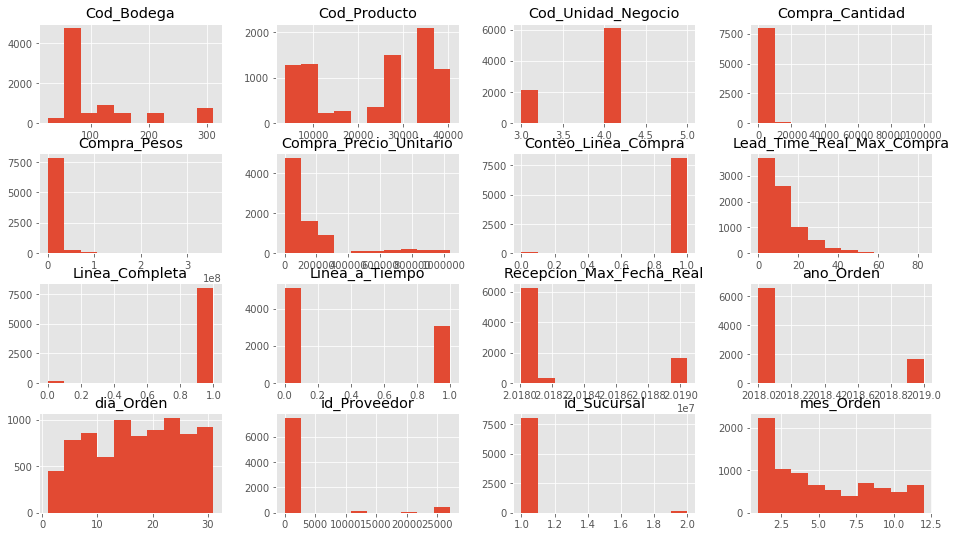

In [47]:
data.drop(['Lead_Time_Teorico_Compra'],1).hist()
plt.show()

## Agrupación y correlación
Para este momento ya tenemos seleccionadas las columnas que esperamos tengan y aporten un sentido al proceso de clustering. Teniendo nuestras 3 columnas las cruzamos con lead time para entender su comportamiento y mirar si tienen alguna relación

F:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


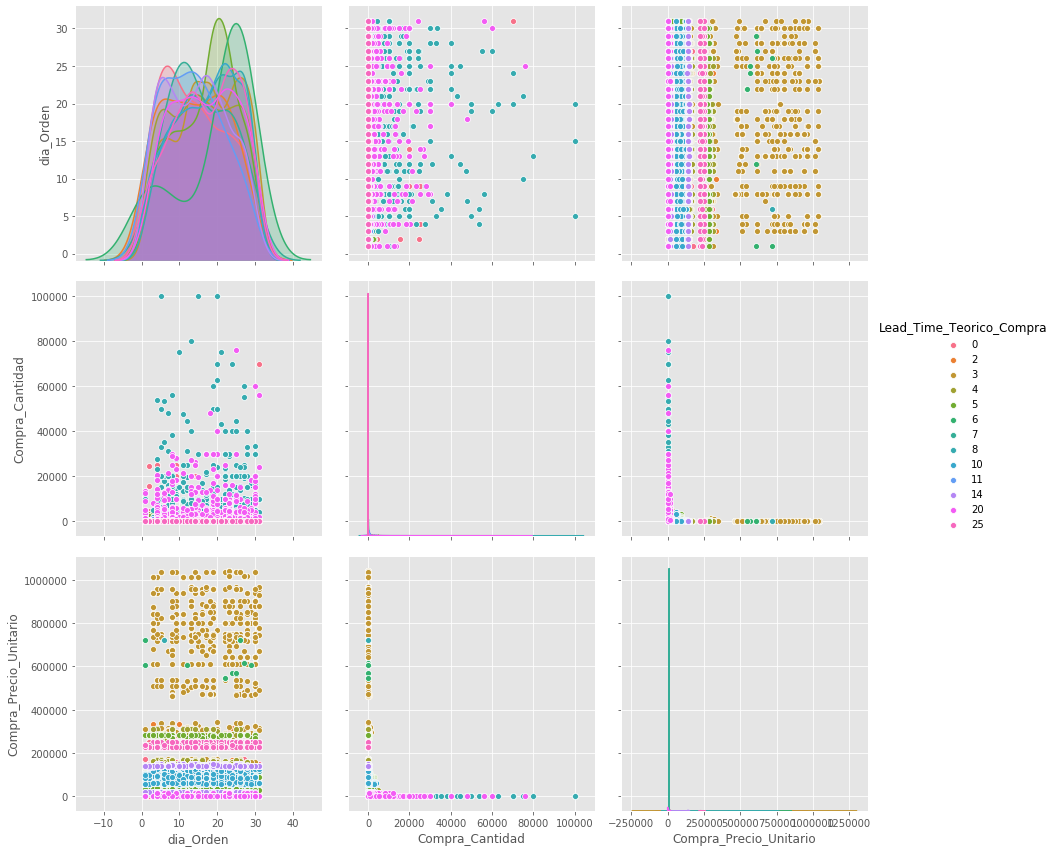

In [48]:
sb.pairplot(data.dropna(), hue='Lead_Time_Teorico_Compra',size=4,vars=["dia_Orden","Compra_Cantidad","Compra_Precio_Unitario"],kind='scatter')

In [49]:
X = np.array(data[["dia_Orden","Compra_Cantidad","Compra_Precio_Unitario"]])
y = np.array(data['Lead_Time_Teorico_Compra'])
X.shape

(8195, 3)

## Gráfica 3D
Esta gráfica nos muestra en 3 dimensiones el comportamiento de los Lead time en base a su dispersión cuando es cruzado con dia de orden, cantidad y precio por unidad.

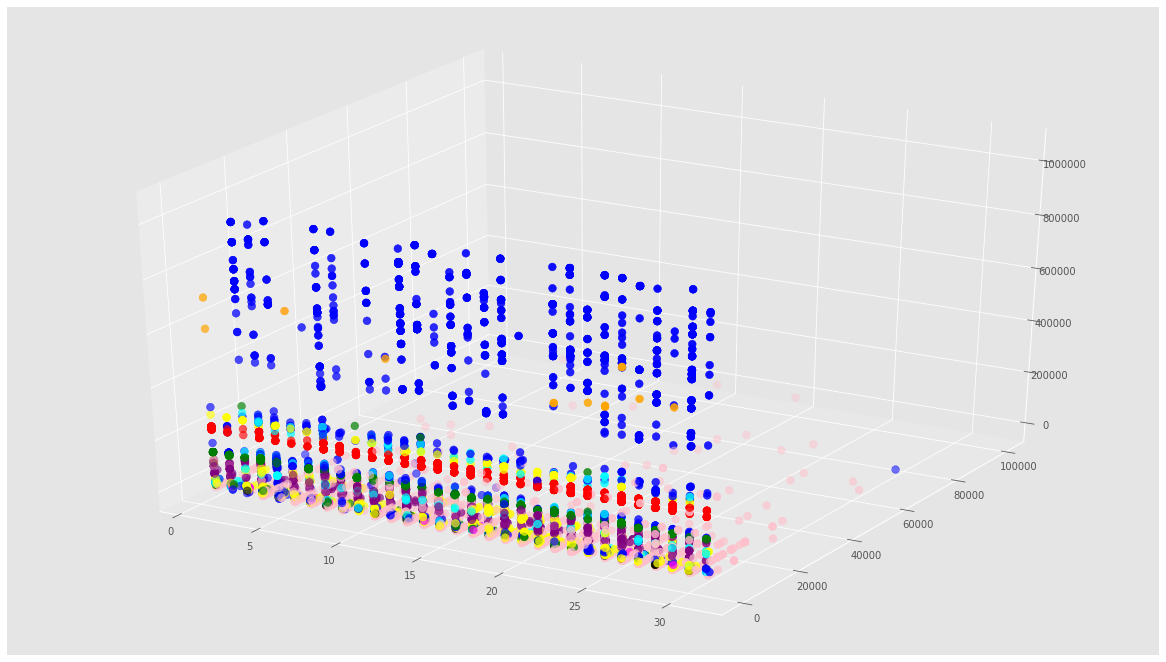

In [50]:
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple', 'magenta', 'blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple', 'magenta', 'blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple', 'magenta']
asignar=[]
for row in y:
    asignar.append(colores[row])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)

## Método del codo
Para escoger el correcto valor de K (número de clusters) se aplicó el método del codo el cual consiste en simular desde 1 hasta N y observar donde la gráfica sufre un cambio brusco, ese cambio brusco vendria a ser nuestro K "ideal".

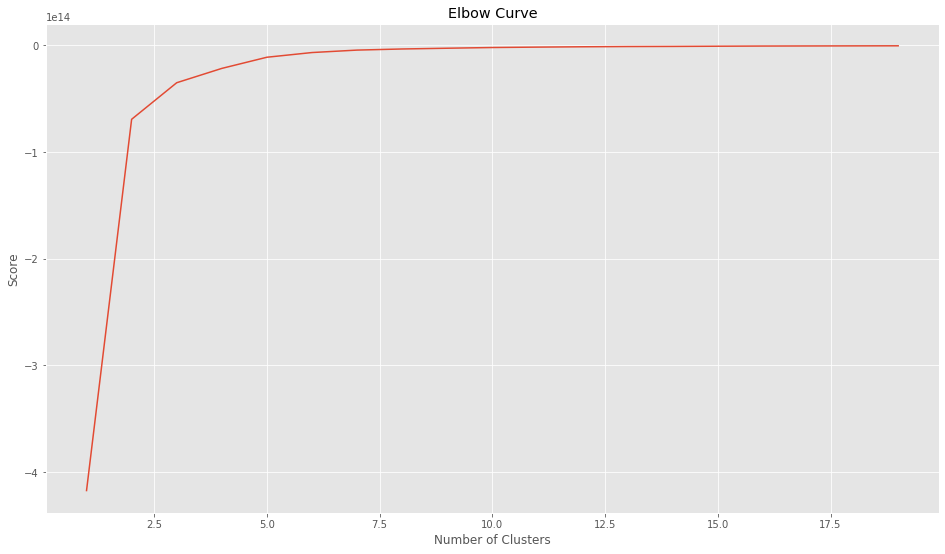

In [51]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Creación de los clusters
para esta fase se crean los clusters y  se calculan sus centroides

In [52]:
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[1.63027782e+01 1.55961466e+03 6.52003255e+04]
 [1.86270492e+01 1.71926230e+01 8.08580876e+05]
 [1.64926740e+01 3.18021978e+01 2.83940076e+05]]


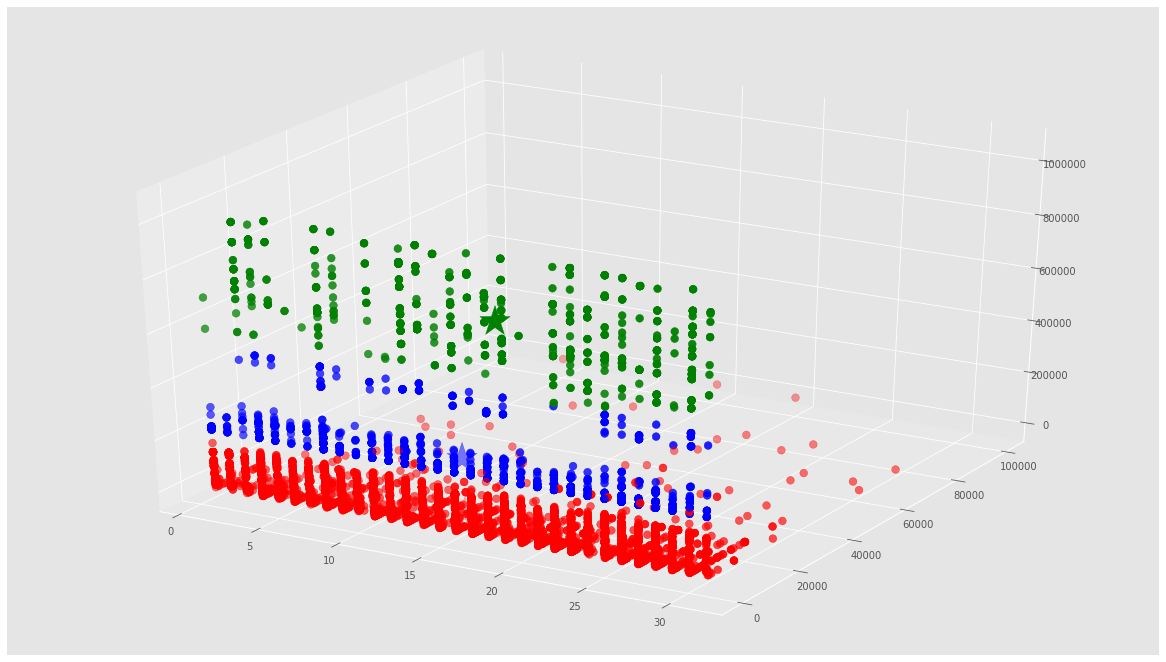

In [53]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

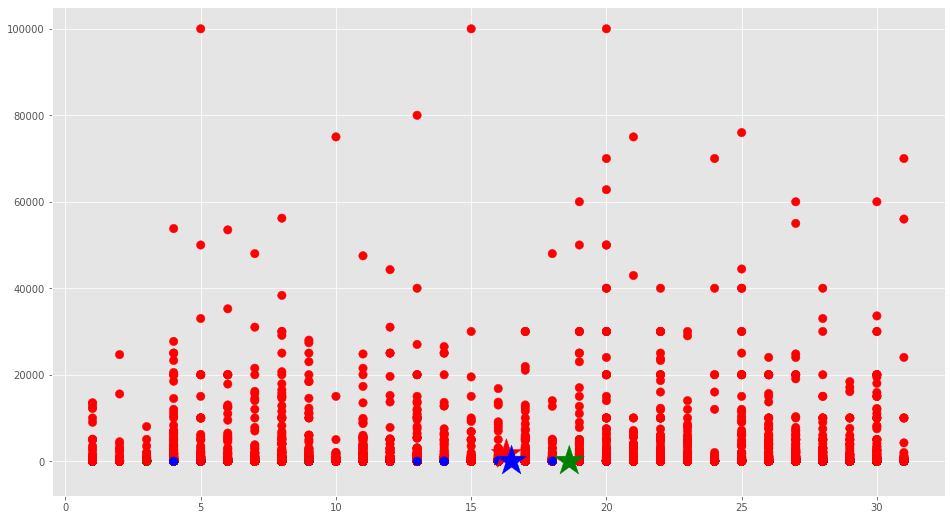

In [54]:
# Getting the values and plotting it
f1 = data['dia_Orden'].values
f2 = data['Compra_Cantidad'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

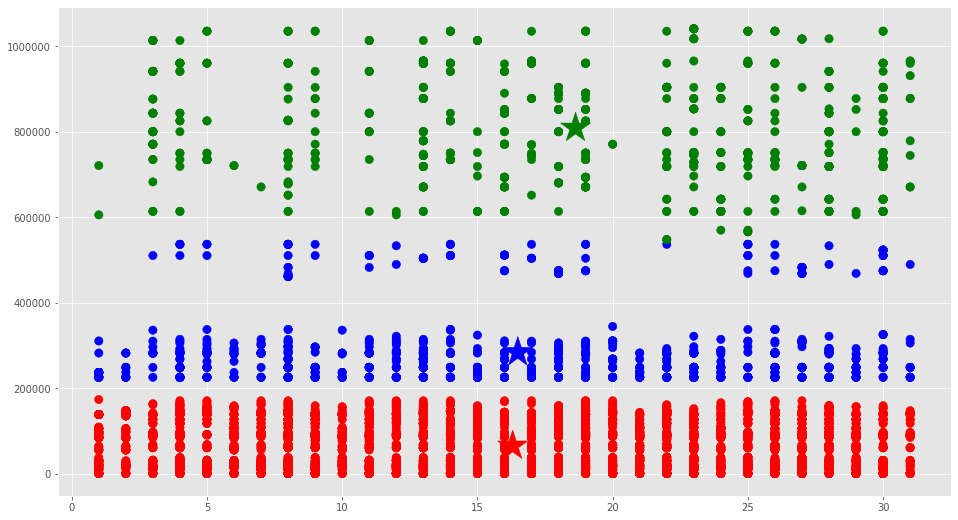

In [55]:
# Getting the values and plotting it
f1 = data['dia_Orden'].values
f2 = data['Compra_Precio_Unitario'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

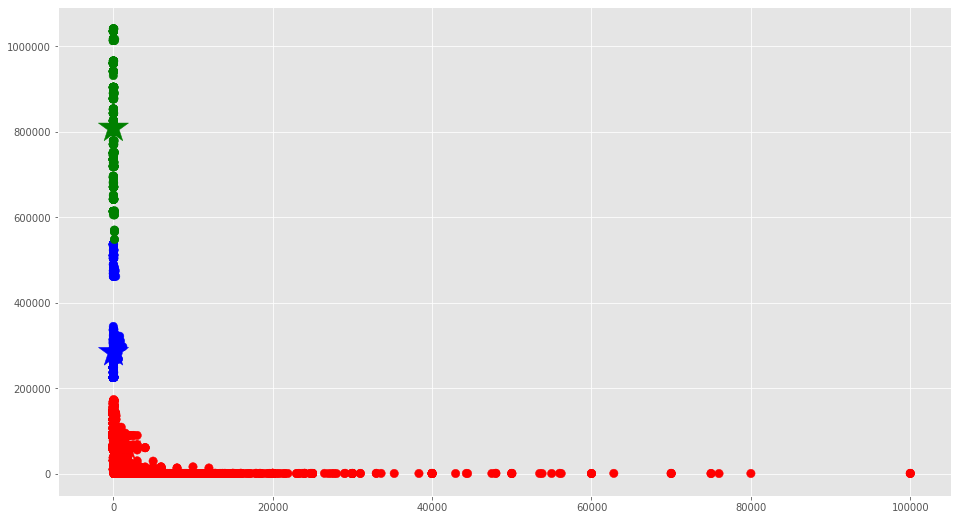

In [56]:
f1 = data['Compra_Cantidad'].values
f2 = data['Compra_Precio_Unitario'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

## Métricas de calidad
Para validar la calidad de los clusters generados se usé el método de silueta que consiste en calcular la distancia entre los resultados de los clusters. 
Esta medida varia entre [-1,1] donde entre mas cercano se encuentre a 1 mayor va a ser su calidad.

For n_clusters = 3 The average silhouette_score is : 0.6986390702043216


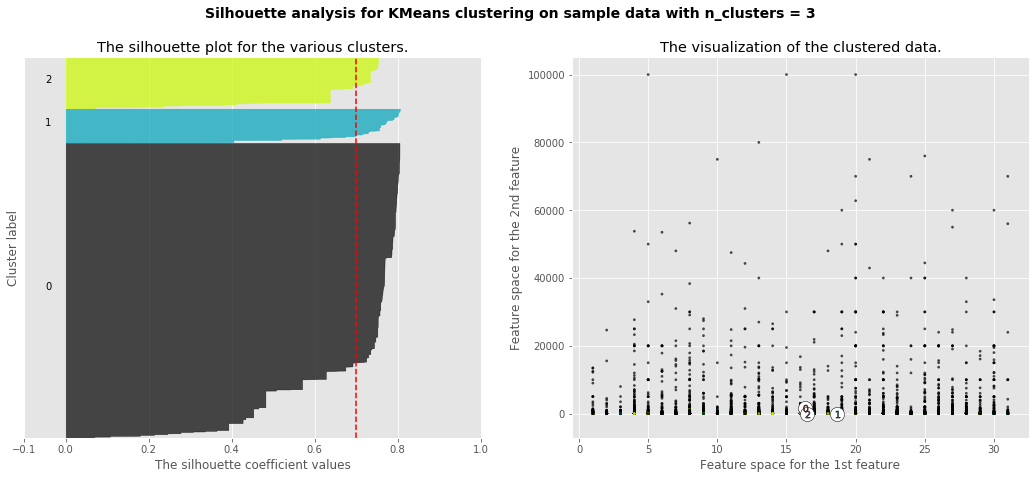

In [62]:

n_clusters = 3


# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = kmeans
cluster_labels = labels

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()